# Week 1: Making Data-Driven Decisions in RAG Applications

> **Prerequisites:** Before starting this notebook, please run the `1. synthetic_questions.ipynb` notebook to generate the evaluation dataset we'll use for our experiments.

When building RAG systems, intuition isn't enough - we need objective metrics to guide our decisions. Teams often waste resources on complex architectures without clear evidence they outperform simpler approaches.

Our own experiments revealed several counterintuitive findings:

1. Embedding search outperformed hybrid search in both recall and MRR metrics
2. Upgrading from `text-embedding-3-small` to `text-embedding-3-large` provided better performance gains than adding a re-ranker
3. For our specific use case, the simpler architecture (pure embedding search) actually performed better than more complex alternatives

This notebook introduces a systematic framework for evaluating and comparing different retrieval strategies.

## Why This Matters

Consider this common scenario: Your team is debating whether to add a re-ranker to your retrieval pipeline. The re-ranker promises better results but adds latency and cost. Without objective metrics, you might invest in unnecessary complexity.

Learning how to objectively measure performance gains is crucial for making informed decisions about your RAG architecture, measure real-world tradeoffs and make evidence-based architectural decisions.

## What you'll learn

Through hands-on experiments with a Text-to-SQL retrieval system, you'll discover:

1. **Understanding Retrieval Metrics**
   - Choose appropriate metrics for your use case
   - Understand tradeoffs between different metrics
   - Learn when to use recall vs MRR
2. **Implementing Evaluation Pipelines**
   - Set up reproducible benchmarks
   - Compare different retrieval strategies
   - Measure performance consistently
3. **Making Data-Driven Decisions**
   - Evaluate cost-benefit tradeoffs
   - Compare architectural alternatives
   - Build evidence-based systems

By the end of this notebook, you'll have a reproducible methodology for evaluating retrieval components and a framework for making data-driven decisions about your RAG architecture.


## Setting up Our Retrieval Pipeline

In this example, we're using a local `lancedb` instance. We're doing so because of 3 reasons.

1. LanceDB handles the embeddings of our data for us
2. It provides embedding search, hybrid search and other re-ranking methods all within a single api.
3. We can use Pydantic to define our table schema and easily ingest our data.

This makes it quick and easy for us to compare the performance of each method.


In [1]:
import datasets
import lancedb
from lancedb.pydantic import LanceModel, Vector
from lancedb.embeddings import get_registry
from lancedb.table import Table


def get_or_create_lancedb_table(db: Table, table_name: str, embedding_model: str):
    if table_name in db.table_names():
        print(f"Table {table_name} already exists")
        table = db.open_table(table_name)
        table.create_fts_index("query", replace=True)
        return table

    func = get_registry().get("openai").create(name=embedding_model)

    class Chunk(LanceModel):
        id: str
        query: str = func.SourceField()
        vector: Vector(func.ndims()) = func.VectorField()

    table = db.create_table(table_name, schema=Chunk, mode="overwrite")
    dataset = datasets.load_dataset("567-labs/bird-rag")["train"]
    formatted_dataset = [{"id": item["id"], "query": item["query"]} for item in dataset]
    table.add(formatted_dataset)

    table.create_fts_index("query", replace=True)
    print(f"{table.count_rows()} chunks ingested into the database")
    return table


# Create LanceDB Instance
db = lancedb.connect("./lancedb")

table_small = get_or_create_lancedb_table(
    db, "chunks_text_embedding_3_small", "text-embedding-3-small"
)
table_large = get_or_create_lancedb_table(
    db, "chunks_text_embedding_3_large", "text-embedding-3-large"
)

/Users/ivanleo/Documents/coding/systematically-improving-rag/cohort_2/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Table chunks_text_embedding_3_small already exists
Table chunks_text_embedding_3_large already exists


### Defining Metrics

> **Important** : In this case because we have a single relevant chunk, each individual query's recall will be 0 or 1. However, the reason why we have a recall metric below that is between 0 and 1 is because we are taking the average of all these individual recall values we compute for different levels of k

Let's now start by evaluating the retrieval performance of our model. We'll do so by measuring the recall and MRR at different levels of k.

$$ \text{Recall} = \frac{\text{Number of Relevant Items Retrieved}}{\text{Total Number of Relevant Items}} $$

$$ \text{MRR} = \frac{\sum\_{i=1}^{n} \frac{1}{rank(i)}}{n} $$

As models improve, their context window and reasoning abilities improve. This means that their ability to select relevant information in response to a user query will improve. By optimizing for recall, we ensure that the language model has access to all necessary information, which can lead to more accurate and reliable generated responses.

MRR@K is a useful metric if we want to display retrieved results as citations to users. We normally show a smaller list of retrieved results to users and we want to make sure that the correct result is ranked highly during retrieval so that it's more likely to be selected.


In [2]:
def calculate_mrr(predictions: list[str], gt: list[str]):
    mrr = 0
    for label in gt:
        if label in predictions:
            # Find the relevant item that has the smallest index
            mrr = max(mrr, 1 / (predictions.index(label) + 1))
    return mrr


def calculate_recall(predictions: list[str], gt: list[str]):
    # Calculate the proportion of relevant items that were retrieved
    return len([label for label in gt if label in predictions]) / len(gt)

## Evaluating Our Retrieval

Now that we understand what metrics we'd like to track, let's see how we can use `pydantic-evals` to measure the performance of our retrieval. 

We'll do so in 3 steps

1. First we'll load in our dataset that we generated in the previous notebook using the `Dataset.from_file` method
2. Then we'll define our evaluators that will generate a series of scores for each individual test case
3. Lastly, we'll then run our evaluation, parameterizing our evaluators on each run to compare different approaches


We want to understand how each method performs when we vary the size of retrieve items with respect to recall and mrr. This helps us understand if a method is worth the cost and latency to implement.

More practically, if a cheaper method has a recall@10 that's equivalent to a more expensive's method recall@5, then it might be worth it to start with the cheaper method first. Using these objective metrics, we can make an informed decision about which method to use. Let's see how we can do so with a simple example below.

In [33]:
from lancedb.rerankers import CohereReranker
import lancedb
from lancedb.table import Table
from lancedb.rerankers import Reranker
from typing import Literal, Optional

db = lancedb.connect("./lancedb")

# Define Our Metrics
metrics = [("recall", calculate_recall), ("mrr", calculate_mrr)]
k = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40]


def retrieve(
    question: str,
    table: Table,
    max_k=25,
    mode: Literal["vector", "fts", "hybrid"] = "vector",
    reranker: Optional[Reranker] = None,
):
    results = table.search(question, query_type=mode).limit(max_k)
    if reranker:
        results = results.rerank(reranker=reranker)
    return [
        {"id": result["id"], "query": result["query"]} for result in results.to_list()
    ]


In [34]:
from pydantic import BaseModel
from dataclasses import dataclass
from pydantic_evals.evaluators import Evaluator, EvaluatorContext
import asyncio
from concurrent.futures import ThreadPoolExecutor
from functools import partial


class ChunkEval(BaseModel):
    chunk_id: str
    question: str
    chunk: str


@dataclass
class RagMetricsEvaluator(Evaluator):
    async def evaluate(self, ctx: EvaluatorContext[str, str]) -> float:
        predictions = ctx.output
        labels = ctx.expected_output

        scores = {}

        for metric, score_fn in metrics:
            for subset_k in k:
                scores[f"{metric}@{subset_k}"] = score_fn(
                    predictions[:subset_k], labels
                )

        return scores


async def retrieve_results(
    question: str,
    table: Table,
    pool: ThreadPoolExecutor,
    max_k=80,
    mode="vector",
    reranker=None,
):
    loop = asyncio.get_running_loop()
    resp = await loop.run_in_executor(
        pool,
        partial(retrieve, question, table, max_k=max_k, mode=mode, reranker=reranker),
    )
    return [item["id"] for item in resp]

In [5]:
import dotenv

dotenv.load_dotenv()

True

In [35]:
from pydantic_evals import Dataset
import concurrent.futures

import logfire

logfire.configure(
    send_to_logfire=True,
    environment="experimentation",
    service_name="benchmark_retrieval",
)

evaluation_queries = Dataset.from_file("questions.yaml")
evaluation_queries.add_evaluator(RagMetricsEvaluator())

with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    result = await evaluation_queries.evaluate(partial(retrieve_results, table=table_small, pool=executor))

11:36:53.266 evaluate retrieve_results
11:36:53.268   case: question_0
11:36:53.268     execute retrieve_results
11:36:53.268   case: question_1
11:36:53.268     execute retrieve_results
11:36:53.269   case: question_2
11:36:53.269     execute retrieve_results
11:36:53.269   case: question_3
11:36:53.270     execute retrieve_results
11:36:53.270   case: question_4
11:36:53.270     execute retrieve_results
11:36:53.270   case: question_5
11:36:53.270     execute retrieve_results
11:36:53.271   case: question_6
11:36:53.272     execute retrieve_results
11:36:53.272   case: question_7
11:36:53.272     execute retrieve_results
11:36:53.274   case: question_8
11:36:53.274     execute retrieve_results
11:36:53.274   case: question_9
11:36:53.274     execute retrieve_results
11:36:53.275   case: question_10
11:36:53.275     execute retrieve_results
11:36:53.275   case: question_11
11:36:53.275     execute retrieve_results
11:36:53.275   case: question_12
11:36:53.276     execute retrieve_resu

Logfire project URL: ]8;id=803797;https://logfire-us.pydantic.dev/ivanleomk/logfire-demo\https://logfire-us.pydantic.dev/ivanleomk/logfire-demo]8;;\

In [36]:
from pydantic_evals.evaluators import EvaluationResult
import tabulate


def visualise_scores(result: EvaluationResult):
    scores = result.averages().scores
    # Format the scores in a more readable way
    formatted_scores = {
        k: round(v, 2) if isinstance(v, float) else v for k, v in scores.items()
    }

    # Create a table with metrics as rows for better readability
    rows = []
    for k, v in formatted_scores.items():
        rows.append([k, v])

    print(tabulate.tabulate(rows, headers=["Metric", "Score"], tablefmt="grid"))


visualise_scores(result)

+-----------+---------+
| Metric    |   Score |
+===========+=========+
| recall@1  |    0.46 |
+-----------+---------+
| recall@3  |    0.73 |
+-----------+---------+
| recall@5  |    0.79 |
+-----------+---------+
| recall@10 |    0.91 |
+-----------+---------+
| recall@15 |    0.95 |
+-----------+---------+
| recall@20 |    0.97 |
+-----------+---------+
| recall@25 |    0.98 |
+-----------+---------+
| recall@30 |    0.99 |
+-----------+---------+
| recall@35 |    0.99 |
+-----------+---------+
| recall@40 |    0.99 |
+-----------+---------+
| mrr@1     |    0.46 |
+-----------+---------+
| mrr@3     |    0.58 |
+-----------+---------+
| mrr@5     |    0.6  |
+-----------+---------+
| mrr@10    |    0.61 |
+-----------+---------+
| mrr@15    |    0.62 |
+-----------+---------+
| mrr@20    |    0.62 |
+-----------+---------+
| mrr@25    |    0.62 |
+-----------+---------+
| mrr@30    |    0.62 |
+-----------+---------+
| mrr@35    |    0.62 |
+-----------+---------+
| mrr@40    |   

### Parameterizing Your Retrieval

Now that we have a vector database with our data inside, we will now use it to evaluate different retrieval methods. Because LanceDB gives us the ability to use different retrieval methods in a single API, we can define a single `retrieve` function that can be easily modified to use different retrieval methods.

Once we've done so, we'll iterate over different subsets of the retrievewd items and compute the recall and mrr metrics.


In [37]:
import uuid
from itertools import product

# Evaluation configurations
available_rerankers = {
    "rerank-english-v3.0": CohereReranker(
        model_name="rerank-english-v3.0", column="query"
    ),
    "none": None,
}

search_query_modes = ["hybrid", "vector"]

embedding_model_to_table = {
    "text-embedding-3-small": table_small,
    "text-embedding-3-large": table_large,
}

evaluation_results = []
experiment_id = str(uuid.uuid4())
for reranker_name, search_mode, embedding_model in product(
    available_rerankers, search_query_modes, embedding_model_to_table
):
    current_reranker = available_rerankers[reranker_name]
    current_table = embedding_model_to_table[embedding_model]

    print(f"Running {reranker_name} with {search_mode} and {embedding_model}")
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        result = await evaluation_queries.evaluate(
            partial(
                retrieve_results,
                pool=executor,
                max_k=80,
                table=current_table,
                mode=search_mode,
                reranker=current_reranker,
            ),
            name=f"{experiment_id}-{embedding_model}-{search_mode}-{reranker_name}",
        )

        # For each of the metrics, we'll then append the results to our evaluation results list
        for metric_name in result.averages().scores:
            metric_type, top_k = metric_name.split("@")
            evaluation_results.append(
                {
                    "metric": metric_type,
                    "k": int(top_k),
                    "reranker": reranker_name,
                    "embedding_model": embedding_model,
                    "query_type": search_mode,
                    "score": round(result.averages().scores[metric_name],4),
                }
            )

Running rerank-english-v3.0 with hybrid and text-embedding-3-small
11:37:20.068 evaluate c5b2c1ec-90a1-452c-a070-b8091df41ec6-text-embedding-3-small-hybrid-rerank-english-v3.0
11:37:20.142   case: question_0
11:37:20.142     execute retrieve_results
11:37:20.143   case: question_1
11:37:20.143     execute retrieve_results
11:37:20.143   case: question_2
11:37:20.143     execute retrieve_results
11:37:20.144   case: question_3
11:37:20.144     execute retrieve_results
11:37:20.144   case: question_4
11:37:20.144     execute retrieve_results
11:37:20.145   case: question_5
11:37:20.145     execute retrieve_results
11:37:20.146   case: question_6
11:37:20.146     execute retrieve_results
11:37:20.147   case: question_7
11:37:20.147     execute retrieve_results
11:37:20.147   case: question_8
11:37:20.148     execute retrieve_results
11:37:20.148   case: question_9
11:37:20.149     execute retrieve_results
11:37:20.149   case: question_10
11:37:20.149     execute retrieve_results
11:37:20.

## Comparing Different Methods

When comparing different methods, it's important to consider the trade offs between them. We want to see how each method performs with respect to recall and MRR.

In this portion, we'll look at how we can do so by two comparisons

1. Comparing the performance of the `text-embedding-3-small` and `text-embedding-3-large` models with respect to recall and MRR
2. Comparing the performance of a re-ranker as we change the `k` muliplier


### Organising Your Data in a Tidy Format

When we change or add experiment parameters, we want to minimize changes to our code. This makes it easier to test different configurations so we can make informed decisions about which method to use.

Let's look at two different ways that we could have organised our data above.

| Method           | MRR@1 | MRR@3 | MRR@5 | Recall@1 | Recall@3 | Recall@5 |
| ---------------- | ----- | ----- | ----- | -------- | -------- | -------- |
| Hybrid Search    | 0.1   | 0.3   | 0.4   | 0.1      | 0.7      | 0.8      |
| Embedding Search | 0.1   | 0.3   | 0.4   | 0.1      | 0.7      | 0.8      |

If we want to add a new metric like MRR@10, we'd have to add a new column to this table. This makes it tricky to plot results, perform calculations and update downstream code that relies on this table. That's a lot of effort for a small change that impacts our ability to perform experiments and comparisons quickly. That's why we need to use a tidy format ( Read more about it [here](https://kiwidamien.github.io/what-is-tidy-data.html)).

In a tidy format

1. Each column represents a single variable
2. Each row represents a single observation

For our experiments above, this looks something like this where we have a single row per metric calculated and we can see the parameters used to calculate it. More importantly, adding a new metric ( eg. MRR@10 ) is as easy as adding a new row.

| Method        | Metric | k   | use_reranker | embedding_model        | score |
| ------------- | ------ | --- | ------------ | ---------------------- | ----- |
| Hybrid Search | MRR    | 1   | False        | text-embedding-3-small | 0.1   |
| Hybrid Search | MRR    | 3   | False        | text-embedding-3-small | 0.3   |
| Hybrid Search | MRR    | 5   | False        | text-embedding-3-small | 0.4   |
| Hybrid Search | Recall | 1   | False        | text-embedding-3-small | 0.1   |
| Hybrid Search | Recall | 3   | False        | text-embedding-3-small | 0.7   |
| Hybrid Search | Recall | 5   | False        | text-embedding-3-small | 0.8   |

We can see how we've done so below when we load in the data as a pandas dataframe.


### Comparing Embedding models

We want to compare the two embedding models with respect to recall and MRR. We expect that the larger model will outperform the smaller model.

An easy way to visualise this is to plot the recall and MRR for each embedding model. This allows us to see the performance of each model with respect to recall and MRR.


In [41]:
import pandas as pd

df = pd.DataFrame(evaluation_results)
df

,metric,k,reranker,embedding_model,query_type,score
0,recall,1,rerank-english-v3.0,text-embedding-3-small,hybrid,0.6414
1,recall,3,rerank-english-v3.0,text-embedding-3-small,hybrid,0.7897
2,recall,5,rerank-english-v3.0,text-embedding-3-small,hybrid,0.8552
3,recall,10,rerank-english-v3.0,text-embedding-3-small,hybrid,0.9448
4,recall,15,rerank-english-v3.0,text-embedding-3-small,hybrid,0.9586
...,...,...,...,...,...,...
155,mrr,20,none,text-embedding-3-large,vector,0.7907
156,mrr,25,none,text-embedding-3-large,vector,0.7913
157,mrr,30,none,text-embedding-3-large,vector,0.7913
158,mrr,35,none,text-embedding-3-large,vector,0.7913


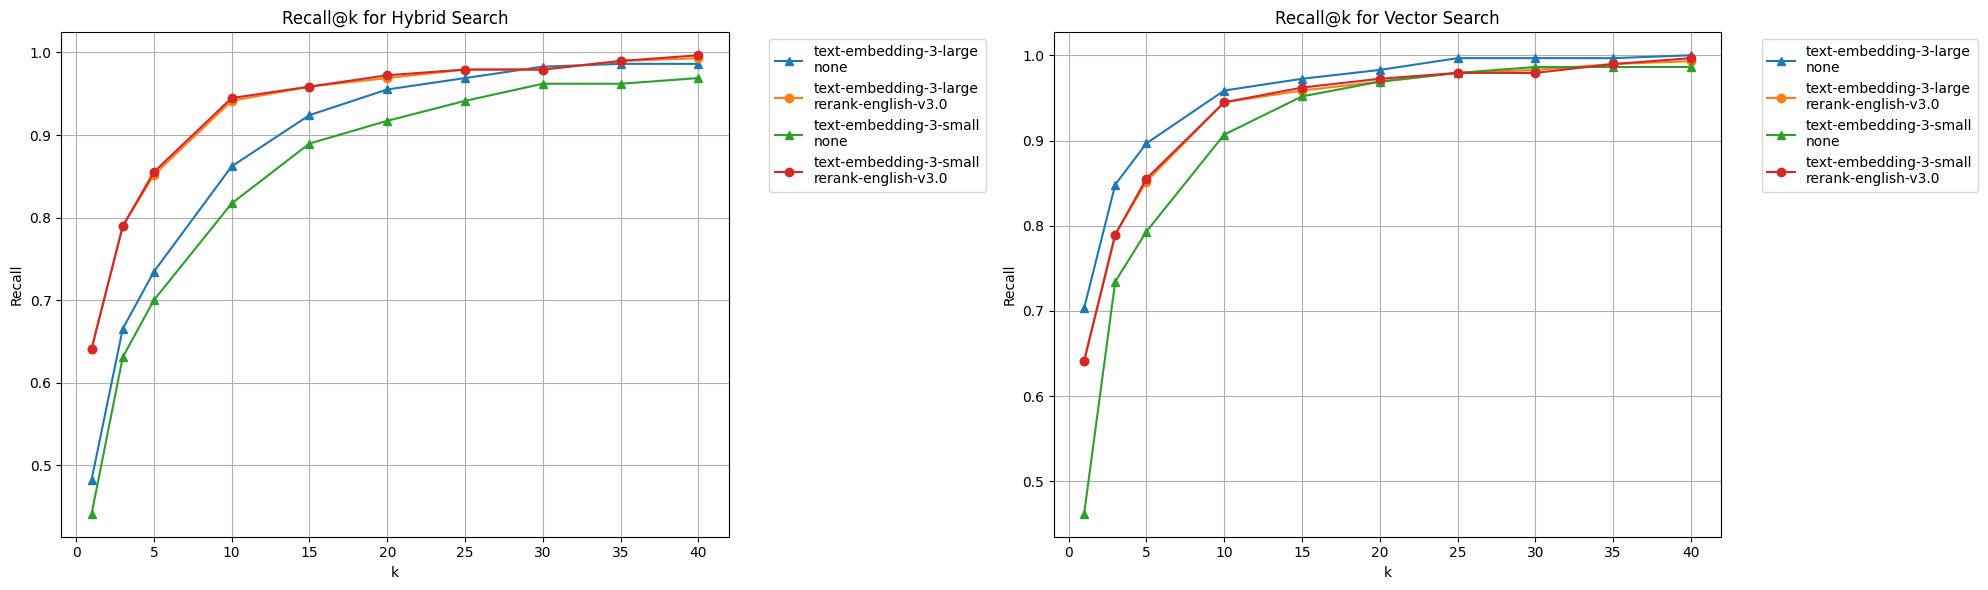

In [39]:
import matplotlib.pyplot as plt

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot recall for hybrid search
hybrid_data = df[(df["metric"] == "recall") & (df["query_type"] == "hybrid")]
for model in sorted(df["embedding_model"].unique()):
    for reranker in sorted(df["reranker"].unique()):
        data = hybrid_data[
            (hybrid_data["reranker"] == reranker)
            & (hybrid_data["embedding_model"] == model)
        ]
        if len(data) > 0:
            marker = "o" if reranker != "none" else "^"
            ax1.plot(
                data["k"], data["score"], marker=marker, label=f"{model}\n{reranker}"
            )

ax1.set_title("Recall@k for Hybrid Search")
ax1.set_xlabel("k")
ax1.set_ylabel("Recall")
ax1.grid(True)
ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

# Plot recall for vector search
vector_data = df[(df["metric"] == "recall") & (df["query_type"] == "vector")]
for model in sorted(df["embedding_model"].unique()):
    for reranker in sorted(df["reranker"].unique()):
        data = vector_data[
            (vector_data["reranker"] == reranker)
            & (vector_data["embedding_model"] == model)
        ]
        if len(data) > 0:
            marker = "o" if reranker != "none" else "^"
            ax2.plot(
                data["k"], data["score"], marker=marker, label=f"{model}\n{reranker}"
            )

ax2.set_title("Recall@k for Vector Search")
ax2.set_xlabel("k")
ax2.set_ylabel("Recall")
ax2.grid(True)
ax2.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

We can also plot the recall for hybrid and vector search with respect to MRR as seen below.

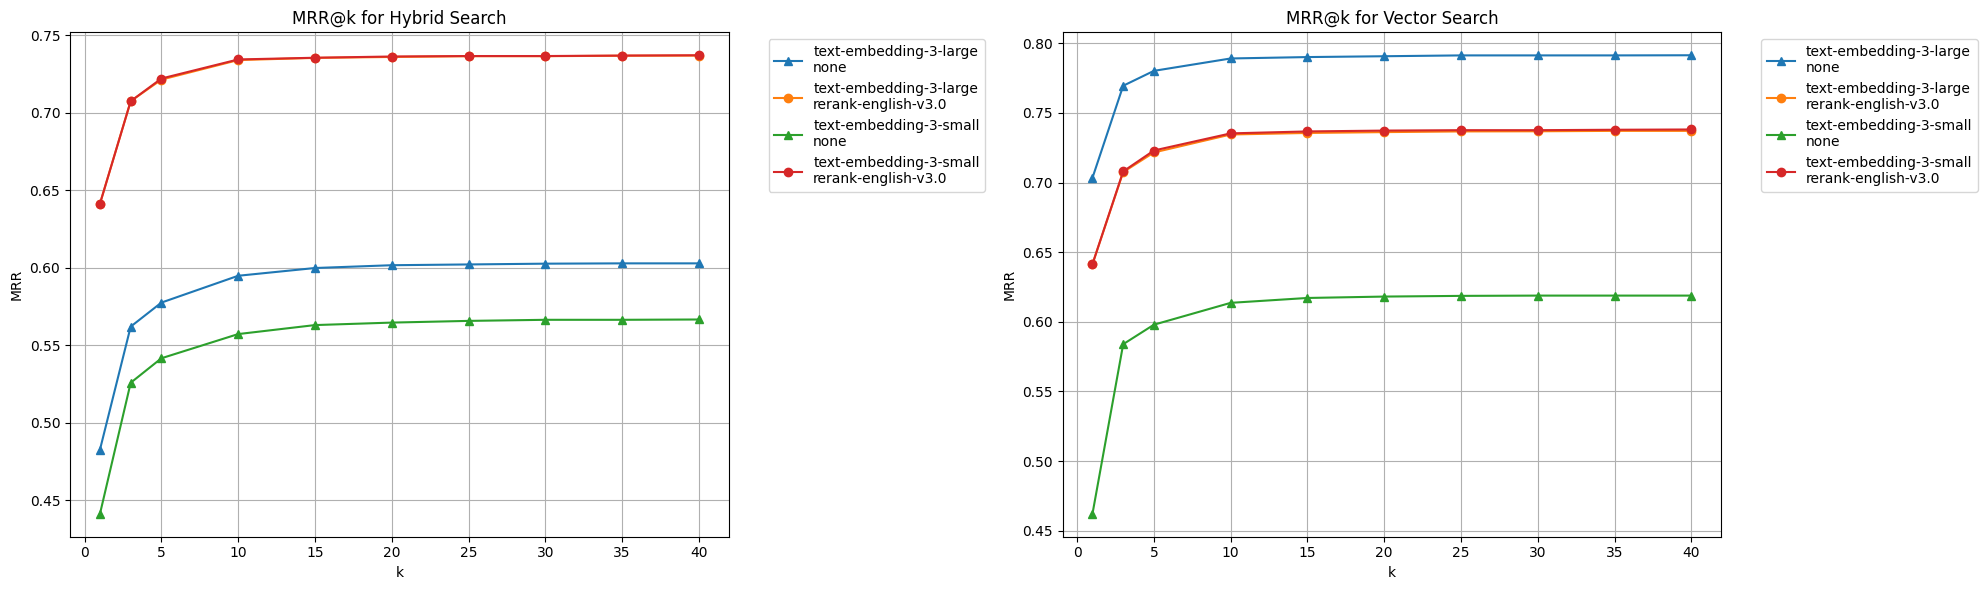

In [40]:
import matplotlib.pyplot as plt

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot MRR for hybrid search
hybrid_data = df[(df["metric"] == "mrr") & (df["query_type"] == "hybrid")]
for model in sorted(df["embedding_model"].unique()):
    for reranker in sorted(df["reranker"].unique()):
        data = hybrid_data[
            (hybrid_data["reranker"] == reranker)
            & (hybrid_data["embedding_model"] == model)
        ]
        if len(data) > 0:
            marker = "o" if reranker != "none" else "^"
            ax1.plot(
                data["k"], data["score"], marker=marker, label=f"{model}\n{reranker}"
            )

ax1.set_title("MRR@k for Hybrid Search")
ax1.set_xlabel("k")
ax1.set_ylabel("MRR")
ax1.grid(True)
ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

# Plot MRR for vector search
vector_data = df[(df["metric"] == "mrr") & (df["query_type"] == "vector")]
for model in sorted(df["embedding_model"].unique()):
    for reranker in sorted(df["reranker"].unique()):
        data = vector_data[
            (vector_data["reranker"] == reranker)
            & (vector_data["embedding_model"] == model)
        ]
        if len(data) > 0:
            marker = "o" if reranker != "none" else "^"
            ax2.plot(
                data["k"], data["score"], marker=marker, label=f"{model}\n{reranker}"
            )

ax2.set_title("MRR@k for Vector Search")
ax2.set_xlabel("k")
ax2.set_ylabel("MRR")
ax2.grid(True)
ax2.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

The results show distinct patterns across model configurations. In hybrid search, text-embedding-3-large maintains a 0.05 point lead over its smaller variant for all k values. Vector search shows an initial gap between models that diminishes as k increases, with text-embedding-3-large reaching near-perfect recall at k=25. MRR differences hold steady at 0.1 for both search types.

Re-ranking analysis reveals limited benefits. While it initially improves hybrid search recall for text-embedding-3-large, text-embedding-3-large matches this at k=30 without added latency. 

In vector search, text-embedding-3-large outperforms the re-ranker consistently, achieving perfect recall at k=25. The re-ranker's only notable advantage is in hybrid search MRR, where it maintains a 0.12 point improvement.

These findings suggest that starting with text-embedding-3-large alone would be a pragmatic choice for an initial deployment, offering two major benefits:

1. Lower Query Latency: Processing overhead is shifted to ingestion time rather than search time, making searches faster for users.
2. Strong Performance: Achieves high recall and MRR scores without the added complexity and latency of a re-ranker.

By using objective metrics that we can compute through a series of experiments, we're able to make more informed decisions about the methods to use. This allows us to make more data-driven decisions about our RAG system that move the needle.

### How many items should we pass into the re-ranker?

We want to know how the performance of the re-ranker changes as we vary the number of items passed into it. This is important because the more items we pass into the re-ranker, the higher the latency.

Therefore, if we can get a good recall@k with a smaller `k`, we should choose that method. Let's modify our earlier code to support this.

We'll be using the text-embedding-3-small model for this experiment with vector search.


In [12]:
from lancedb.rerankers import CohereReranker
import uuid

evaluation_queries = Dataset.from_file("questions.yaml")
evaluation_queries.add_evaluator(RagMetricsEvaluator())

reranker = CohereReranker(model_name="rerank-english-v3.0", column="query")
experiment_id = str(uuid.uuid4())
embedding_model = "text-embedding-3-small"
search_mode = "vector"
reranker_name = "rerank-english-v3.0"


reranker_results = []
for retrieval_limit in [40, 80, 120]:
    # Run evaluation
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        result = await evaluation_queries.evaluate(
            partial(
                retrieve_results,
                pool=executor,
                max_k=retrieval_limit,
                table=table_small,
                mode=search_mode,
                reranker=reranker,
            ),
            name=f"cohere-reranker-{retrieval_limit}",
        )

        # Process benchmark results
        performance_scores = result.averages().scores
        for metric_name in result.averages().scores:
            metric_type, top_k = metric_name.split("@")
            reranker_results.append(
                {
                    "metric": metric_type,
                    "k": int(top_k),
                    "score": performance_scores[metric_name],
                    "retrieval_limit": retrieval_limit,
                }
            )

11:24:35.844 evaluate cohere-reranker-40
11:24:35.845   case: question_0
11:24:35.845     execute retrieve_results
11:24:35.846   case: question_1
11:24:35.846     execute retrieve_results
11:24:35.846   case: question_2
11:24:35.846     execute retrieve_results
11:24:35.847   case: question_3
11:24:35.847     execute retrieve_results
11:24:35.847   case: question_4
11:24:35.848     execute retrieve_results
11:24:35.848   case: question_5
11:24:35.848     execute retrieve_results
11:24:35.848   case: question_6
11:24:35.848     execute retrieve_results
11:24:35.849   case: question_7
11:24:35.849     execute retrieve_results
11:24:35.851   case: question_8
11:24:35.851     execute retrieve_results
11:24:35.851   case: question_9
11:24:35.851     execute retrieve_results
11:24:35.852   case: question_10
11:24:35.852     execute retrieve_results
11:24:35.853   case: question_11
11:24:35.853     execute retrieve_results
11:24:35.853   case: question_12
11:24:35.853     execute retrieve_re

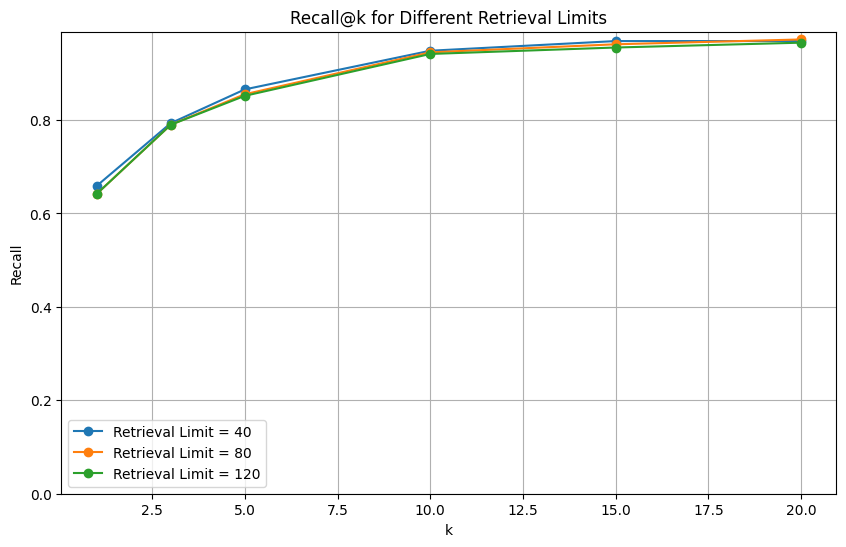

In [13]:
# Filter for recall metric and create plot
reranker_df = pd.DataFrame(reranker_results)
recall_df = reranker_df[reranker_df["metric"] == "recall"]
limits_to_plot = [40, 80, 120]

plt.figure(figsize=(10, 6))
for limit in limits_to_plot:
    data = recall_df[recall_df["retrieval_limit"] == limit]
    plt.plot(data["k"], data["score"], label=f"Retrieval Limit = {limit}", marker="o")

plt.xlabel("k")
plt.ylabel("Recall")
plt.title("Recall@k for Different Retrieval Limits")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

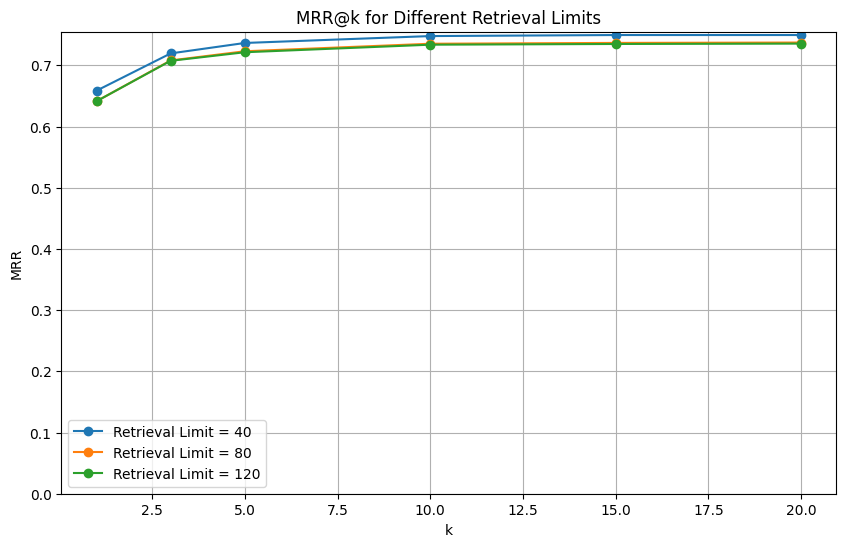

In [14]:
# Filter for recall metric and create plot
recall_df = reranker_df[reranker_df["metric"] == "mrr"]
limits_to_plot = [40, 80, 120]

plt.figure(figsize=(10, 6))
for limit in limits_to_plot:
    data = recall_df[recall_df["retrieval_limit"] == limit]
    plt.plot(data["k"], data["score"], label=f"Retrieval Limit = {limit}", marker="o")

plt.xlabel("k")
plt.ylabel("MRR")
plt.title("MRR@k for Different Retrieval Limits")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

## Conclusion

Our analysis showed that increasing items passed to the re-ranker yielded minimal gains. This fits into a broader pattern of findings from our rigorous comparison of different retrieval strategies:

1. Embedding search outperformed hybrid search in both recall and MRR metrics
2. The choice of embedding model significantly impacted performance
3. Re-ranking provided minimal benefits for our specific use case

These methods provide a foundation for Week 2's fine-tuning work and Week 4's query understanding systems. Early evaluation helps us make informed decisions about which methods to use, this is especially valuable as our RAG system grows more sophisticated.

Remember that these results are specific to our test dataset - your evaluations may yield different insights. In the next notebook, we'll explore statistical techniques to validate that these performance differences are meaningful.
